In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
np.random.seed(0)

In [2]:
def get_mean_cov(data):
    n, m, _ = data.shape
    xm = np.mean(data, axis=0)
    P = np.zeros((m, m))
    for x in data:
        P += np.dot(x-xm, (x-xm).T)/n
    return xm, P

def nonlinear_transform(x):    
    y = x.copy()
    y[0, 0] = 0.4*x[0, 0]**0.8 + 0.6*x[1, 0]**1.2 - 2
    y[1, 0] = 0.8*x[0, 0]**0.8 + 0.2*x[1, 0]**1.2 + 2
    return y

In [3]:
def get_sigma_points(x, P, alpha=1e-3, beta=2, kappa=0):
    n = np.size(x)
    l = np.square(alpha) * (n + kappa) - n
    u = np.linalg.cholesky((n+l)*P)
    
    s = np.zeros((2*n+1, n, 1))
    s[0] = x
    for i in range(n):
        s[i+1] = x + u[i].reshape(-1, 1)
        s[i+n+1] = x - u[i].reshape(-1, 1)
    return s

def get_weights(x, alpha=1e-3, beta=2, kappa=0):
    n = np.size(x)
    l = np.square(alpha) * (n + kappa) - n
    
    wm = np.zeros(2*n+1)
    wc = np.zeros(2*n+1)
    
    wm[0] = l/(n+l)
    wc[0] = l/(n+l) + (1-np.square(alpha)+beta)
    
    for i in range(1, 2*n+1):
        wm[i] = 1/(2*(n+l))
        wc[i] = 1/(2*(n+l))
    return wm

### Data

In [4]:
# Before Non-linear Transform
data_1 = np.random.multivariate_normal([20, 20], [[1, 0.2], [0.2, 1]], size=1000)
data_1 = data_1.reshape(*data_1.shape, 1)
data_1 = np.abs(data_1)

# After Nonlinear Transform
data_2 = np.array([nonlinear_transform(x) for x in data_1])

In [5]:
# Unscented Transform
x, P = get_mean_cov(data_1)
_s = get_sigma_points(x, P, alpha=1e-3, beta=2, kappa=0)
_W = get_weights(x, alpha=1e-3, beta=2, kappa=0)

ut_mean = np.sum([W*nonlinear_transform(s) for s, W in zip(_s, _W)], axis=0)
ut_cov = np.sum([W*np.dot(nonlinear_transform(s)-ut_mean, (nonlinear_transform(s)-ut_mean).T) for s, W in zip(_s, _W)], axis=0)
data_3 = np.random.multivariate_normal(ut_mean.flatten(), ut_cov, size=1000)
data_3 = data_3.reshape(*data_3.shape, 1)

### Result

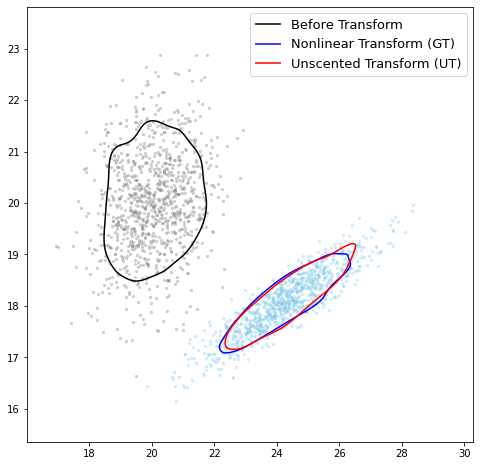

In [6]:
plt.figure(figsize=(8, 8))
sns.kdeplot(x=data_1[:, 0, 0], y=data_1[:, 1, 0], levels=2, thresh=0.3, color='k', label='Before Transform')
plt.scatter(x=data_1[:, 0, 0], y=data_1[:, 1, 0], s=5, color='gray', alpha=0.3)
sns.kdeplot(x=data_2[:, 0, 0], y=data_2[:, 1, 0], levels=2, thresh=0.3, color='b', label='Nonlinear Transform (GT)')
plt.scatter(x=data_2[:, 0, 0], y=data_2[:, 1, 0], s=5, color='skyblue', alpha=0.3)
sns.kdeplot(x=data_3[:, 0, 0], y=data_3[:, 1, 0], levels=2, thresh=0.3, color='r', label='Unscented Transform (UT)')
plt.legend(fontsize=13)
plt.show()

In [7]:
gt_mean, gt_cov = get_mean_cov(data_2)
print(f'GT | MEAN={gt_mean.flatten()} | COV={gt_cov.flatten()}')
print(f'UT | MEAN={ut_mean.flatten()} | COV={ut_cov.flatten()}')

GT | MEAN=[24.26445336 18.08394123] | COV=[1.77744868 0.71166849 0.71166849 0.35781039]
UT | MEAN=[24.26418213 18.08380009] | COV=[1.71669732 0.69290817 0.69290817 0.35509501]
